# Hidden Markov Model
## 1. Theory

Sources: 
- https://www.scirp.org/journal/paperinformation?paperid=82940#:~:text=For%20stock%20traders%2C%20promptly%20predicting,%E2%80%9D%2C%20or%20%E2%80%9CMedium%E2%80%9D.
- https://www.youtube.com/watch?v=9-sPm4CfcD0

Hidden Markov Models are statistical models that predict observable states using hidden states.

Ex. You have three weather patterns: cloudy, sunny, and rainy. They each have their own unique probabilities and patterns. However, suppose we live in a different city, and we cannot see the weather for ourselves. Instead, we have a friend who lives there. Their mood is influenced by the weather, ie. different probabilities of happy or sad based on the cloudy, rainy, and sunny patterns. 

We compute the joint probability of our friend's mood patterns and their city's weather patterns. Maximizing this joint probability gives us the most likely weather sequence given the observed mood sequence. 

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(X = X_1, X_2, ..., X_n) | Y = Y_1, Y_2, ... Y_n)
$$

This is difficult to find, so we use Bayes' Theorem.
$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(Y | X)P(X) / P(Y)
$$

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} \Pi P(Y_i | X_i)P(X_i|X_{i-1})$$


## 2. Objective
We apply the same concept to predicting stock trends. Our hidden states of prediction are uptrend, downtrend, and flat-trend. Our observable states are the prices, volumes, etc.

In [52]:

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Fetch and preprocess data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="60m")
    data.columns = data.columns.get_level_values(0)  # Flatten columns
    #data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1)).replace(-np.inf, 0)

    data['Returns'] = data['Close'].pct_change()
    # data['Log Returns'] = np.log(1 + data['Returns'])
    #print(data.dropna())
    data = data.dropna()
    return data.dropna()

# volume, delta of open/close price

# Step 2: Prepare features
def prepare_features(data):
    data['Volatility'] = data['Returns'].rolling(window=5).std()
    print(data)
    features = data[['Returns', 'Volatility']].dropna().values  # 2D array
    aligned_data = data.dropna(subset=['Returns', 'Volatility'])  # Align with features
    return aligned_data, features

# Step 3: Train HMM
def train_hmm(features, n_states):
    print("Training HMM with features shape:", features.shape)  
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(features)
    hidden_states = model.predict(features)
    return model, hidden_states


def plot_hidden_states(data, hidden_states, n_states):
    plt.figure(figsize=(15, 8))

    # Plot the stock price as a continuous line
    plt.plot(data.index, data['Close'], color='gray', alpha=0.5, label="Stock Price")

    # Define colors for different states
    state_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
    state_colors = state_colors[:n_states]  # Limit colors to the number of states

    # Plot arrows at state transitions
    prev_state = hidden_states[0]
    for i in range(1, len(hidden_states)):
        if hidden_states[i] != prev_state:  # Detect state change
            marker=r'$\uparrow$' if hidden_states[i] == 0 else r'$\downarrow$'  # Up for state 0, down for others
            plt.scatter(data.index[i], data['Close'].iloc[i], 
                        marker=marker, color=state_colors[hidden_states[i]], s=100)
            prev_state = hidden_states[i]

    plt.title("Stock Price by Hidden States")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

def simulate_trading(data, hidden_states):
    data['State'] = hidden_states
    print(data['State'])
    print(data.eq(0).sum(axis=1))
    data['Signal'] = data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
    print(data['Signal'])
    data['Strategy Returns'] = data['Signal'].shift(1) * data['Returns']
    cumulative_strategy_returns = (1 + data['Strategy Returns'].dropna()).cumprod()
    cumulative_market_returns = (1 + data['Returns'].dropna()).cumprod()
    
    plt.figure(figsize=(15, 8))
    plt.plot(cumulative_strategy_returns, label="Strategy Returns")
    plt.plot(cumulative_market_returns, label="Market Returns")
    plt.legend()
    plt.title("Trading Strategy vs. Market")
    plt.show()
    
def calculate_metrics(data):
    # Define actual price movements (up=1, down=0)
    data['Actual_Movement'] = (data['Returns'] > 0).astype(int)
    
    # Define predicted movements based on states
    data['Predicted_Movement'] = (data['State'] == 0).astype(int)
    
    # Calculate metrics
    true_positives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 1))
    false_positives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 1))
    true_negatives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 0))
    false_negatives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 0))
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(data)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nModel Performance Metrics:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1_score:.3f}")
    
    # Create confusion matrix
    print("\nConfusion Matrix:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")

In [53]:
ticker = "AAPL"
from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

# Fetch and preprocess data
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Prepare features
aligned_data, features = prepare_features(stock_data)

# Train HMM
n_states = 3
hmm_model, hidden_states = train_hmm(features, n_states)




[*********************100%***********************]  1 of 1 completed

Price                     Close        High         Low        Open   Volume  \
Datetime                                                                       
2025-01-13 10:30:00  230.725006  231.800003  230.220001  230.380005        0   
2025-01-13 11:30:00  232.320007  232.529999  230.399994  230.732498  2787515   
2025-01-13 12:30:00  233.380005  233.434998  231.979996  232.289993  1927298   
2025-01-13 13:30:00  233.559998  233.970001  233.250000  233.429993  1820262   
2025-01-13 14:30:00  233.684402  234.199997  233.369995  233.550003  2045511   
...                         ...         ...         ...         ...      ...   
2025-02-11 11:30:00  234.572296  235.229996  233.721695  234.660004  5739801   
2025-02-11 12:30:00  233.544998  234.625000  233.250000  234.589996  3044289   
2025-02-11 13:30:00  233.369995  234.189896  233.130005  233.720001  2814146   
2025-02-11 14:30:00  233.110794  233.925003  232.899994  233.362106  3713673   
2025-02-11 15:30:00  232.770004  233.300

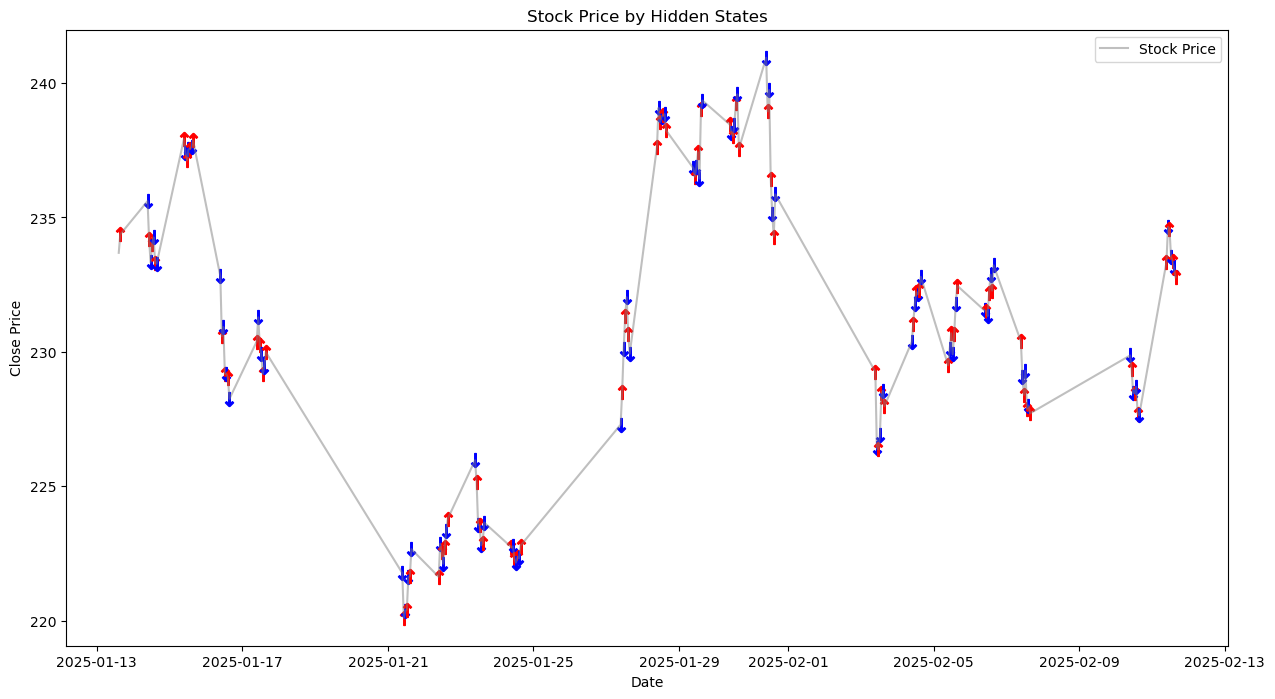

In [54]:
plot_hidden_states(aligned_data, hidden_states, n_states)


In [55]:
print("Hidden states shape:", hidden_states.shape)  
# Plot Hidden States 
aligned_data = aligned_data.copy()  
aligned_data['State'] = hidden_states
aligned_data['Signal'] = aligned_data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
aligned_data['Strategy Returns'] = aligned_data['Signal'].shift(1) * aligned_data['Returns']
calculate_metrics(aligned_data)

Hidden states shape: (142,)

Model Performance Metrics:
Precision: 0.423
Recall: 0.411
Accuracy: 0.408
F1 Score: 0.417

Confusion Matrix:
True Positives: 30
False Positives: 41
True Negatives: 28
False Negatives: 43


Datetime
2025-01-13 14:30:00    1
2025-01-13 15:30:00    0
2025-01-14 09:30:00    1
2025-01-14 10:30:00    0
2025-01-14 11:30:00    1
                      ..
2025-02-11 11:30:00    0
2025-02-11 12:30:00    1
2025-02-11 13:30:00    0
2025-02-11 14:30:00    1
2025-02-11 15:30:00    0
Name: State, Length: 142, dtype: int64
Datetime
2025-01-13 14:30:00    1
2025-01-13 15:30:00    1
2025-01-14 09:30:00    1
2025-01-14 10:30:00    2
2025-01-14 11:30:00    2
                      ..
2025-02-11 11:30:00    2
2025-02-11 12:30:00    2
2025-02-11 13:30:00    2
2025-02-11 14:30:00    2
2025-02-11 15:30:00    2
Length: 142, dtype: int64
Datetime
2025-01-13 14:30:00   -1
2025-01-13 15:30:00    1
2025-01-14 09:30:00   -1
2025-01-14 10:30:00    1
2025-01-14 11:30:00   -1
                      ..
2025-02-11 11:30:00    1
2025-02-11 12:30:00   -1
2025-02-11 13:30:00    1
2025-02-11 14:30:00   -1
2025-02-11 15:30:00    1
Name: Signal, Length: 142, dtype: int64


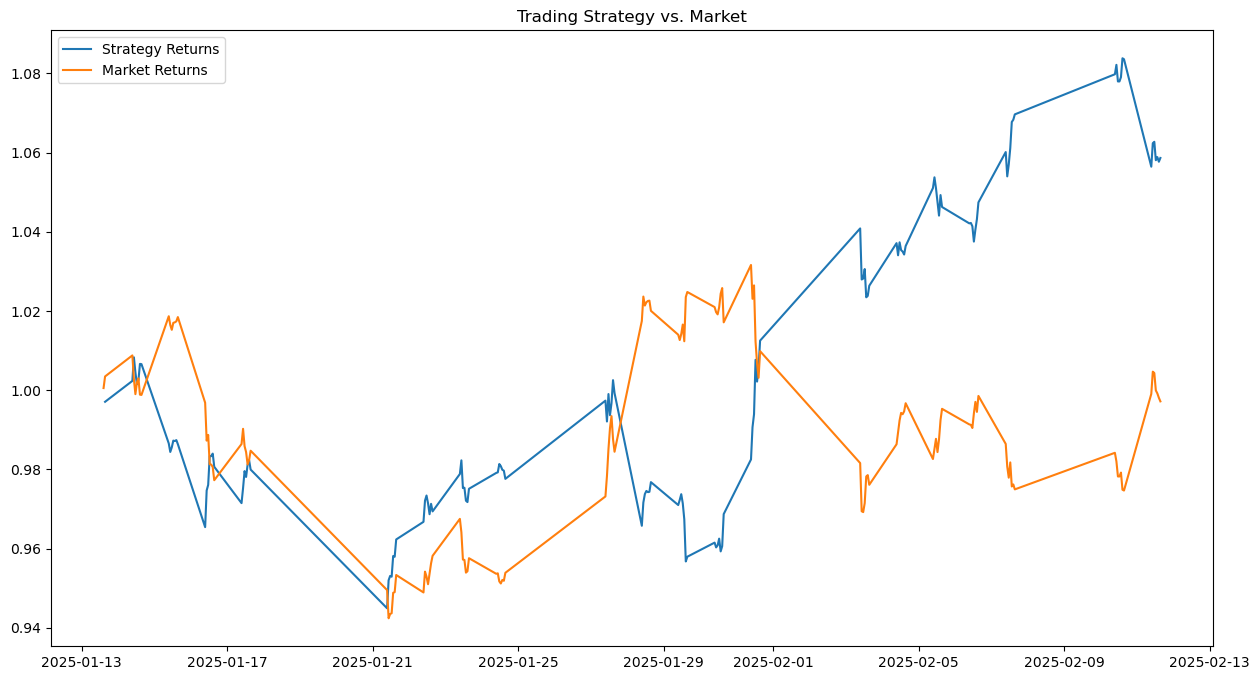

In [38]:
# Simulate Trading Strategy 
simulate_trading(aligned_data, hidden_states)

## Key Findings
